In [ ]:
# Adapted from 
# Beauregard, Stéphane. “Circuit for Shor’s Algorithm Using 2n + 3 Qubits.” arXiv:quant-ph/0205095v3, 
# 21 Feb. 2003. Published 15 May 2002. Quantum Information and Computation, vol. 3, no. 2. doi:10.48550/arXiv.quant‑ph/0205095 


Using the paper cited above, we will develop a function using simple gates that takes two inputs, $a, N \in \mathbb{Z}_+$ such that $a < N$, and outputs the oracle

$$
U \, |x\rangle_1 \, |y\rangle_n =
\begin{cases}
|c\rangle_1 \, |ax \bmod N\rangle_n, & \text{if } c = 1 \text{ and } x < N, \\
|c\rangle_1 \, |x\rangle_n, & \text{otherwise}.
\end{cases}
$$

where $ n = 2 \lceil \log_2(N) \rceil$. It is enough to make it work for $ N = 15$. However, I encourage you to try to implement it for arbitrary $ N $.

We begin by forming the QFT circuit and a function that converts $a$ to an array representing it's binary form.

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from qiskit.circuit.library import PhaseGate

The quantum fourier transform on $n$ qubits implements: $$\text{QFT}|x\rangle = \frac{1}{2^{\frac{n}{2}}} \sum_{k=0}^{2^n - 1} e^{\frac{2 \pi i }{2^n}xk} |k\rangle$$ 

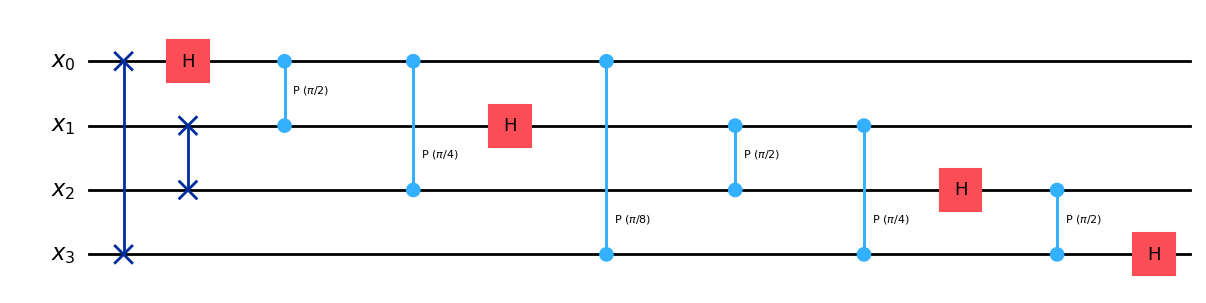

In [4]:
def quantum_fourier_transform(n):
    """
    Creates a Quantum Fourier Transform circuit on n qubits

    Inputs:
    n = Number of qubits

    Output: QFT quantum circuit    
    """
    quantum_register = QuantumRegister(size=n, name="x")
    QFT_circuit = QuantumCircuit(quantum_register, name=f"QFT")

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        QFT_circuit.swap(q, p)

    for i, q in enumerate(quantum_register, start=1):
        QFT_circuit.h(q)
        for j, p in enumerate(quantum_register[i:], start=1):
            QFT_circuit.cp(np.pi / (1 << j), q, p)

    return QFT_circuit

### Example usage and circuit drawing

# number of qubits
n = 4

# draw the quantum circuit
QFT_circuit = quantum_fourier_transform(n)
QFT_circuit.draw("mpl")

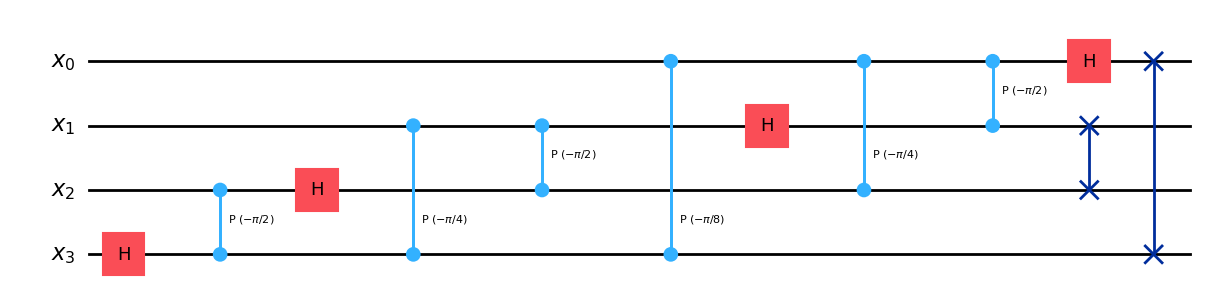

In [6]:
def inverse_quantum_fourier_transform(n):
    """
    Creates an inverse Quantum Fourier Transform circuit on n qubits

    Inputs:
    n = Number of qubits

    Output: Inverse QFT quantum circuit    
    """
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=f"IQFT")

    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
        inverse_QFT_circuit.h(q)

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        inverse_QFT_circuit.swap(q, p)

    return inverse_QFT_circuit

### Example usage and circuit drawing

# number of qubits
n = 4

# draw the quantum circuit
QFTinv_circuit = inverse_quantum_fourier_transform(n)
QFTinv_circuit.draw("mpl")

In [7]:
def int_to_bit_array(a, n):
    """
    Converts an integer, a, to an array where each entry represents a bit, for use in the phiADD circuit

    Inputs:
    a = Integer to add, a < 2**n
    n = Number of qubits

    Output: Array of bits representing "a"
    """
    # Convert integer to binary string
    bin_str = format(a, f'0{n}b')
    # Convert string to array
    return [int(bit) for bit in bin_str]

### Example usage

# number of qubits
n = 4

# integer to add, we must have a < N = 2**n
a = 15

# print the result
a_bits = int_to_bit_array(a,n)
print(a_bits)

[1, 1, 1, 1]


We now create the $\phi ADD(a)$ circuit such that $$|\phi(b) \rangle \rightarrow |\phi(a+b) \rangle$$

where $\phi(b)$ represents the quantum Fourier Transform of $b$, and $\phi(a+b)$ is $(a+b) mod 2^n$.

This circuit takes $n$ qubits to represent $\phi(b)$,and 1 extra qubit as the MSB to prevent overflows. The phase gates for each $n$ are controlled by the classical representation of $a$.

So we have for the $j$th qubit, $$\phi_j(b) = \sum_{k=j}^{n + 1} a_k \cdot \frac{2\pi}{2^{k-j+1}}$$

where $0 \leq k \leq n-1$ and $a_k$ is the value of the $kth$ bit of the binary representation of $a$..

This circuit requires $n+1$ qubits.

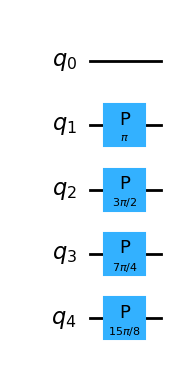

In [8]:
def phiADD(a, n):
    """
    Constructs a quantum phase addition circuit (phiADD) that adds a classical integer `a`
    to a quantum register encoded in the Fourier basis.

    Input: 
    a = Integer to add < 2**N
    n = Number of qubits
    
    Output: Quantum Circuit for quantum phase addition
    """
    
    qc = QuantumCircuit(n + 1, name="phiADD")  # allocate n+1 qubits
    a_bits = int_to_bit_array(a, n)  # convert a to n-bit array

    for j in range(n + 1):
        angle = 0
        for k in range(j, n):  # a_bits has length n
            if a_bits[k] == 1:
                angle += 2 * np.pi / (2 ** (k - j + 1))
        if angle != 0:
            qc.p(angle, n - j)  # match indexing from MSB to LSB
    return qc

### Example usage and circuit drawing

# number of qubits
n = 4

# integer to add, we must have a < N = 2**n
a = 15

# draw the quantum circuit
phiADD_circuit = phiADD(a, n)
phiADD_circuit.draw("mpl")

We now make a single, and doubly controlled version of $\phi ADD(a)$.

When a control qubit is added to the circuit, the depth becomes $O(n)$ because the conditional phse shifts have to be done sequentially, i.e. the control qubit has to control each phase shift one at a time. 

These gates take n+2 and n+3 qubits, respectively.

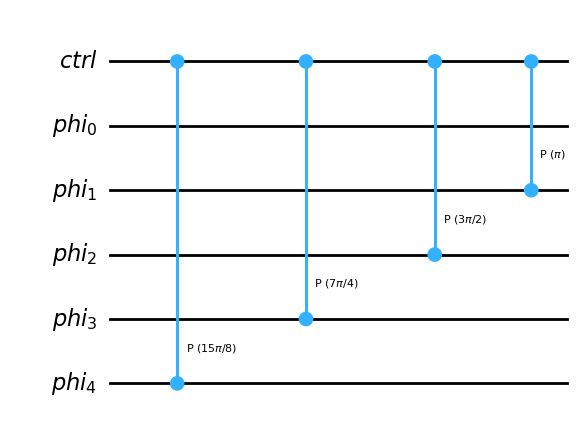

In [9]:
def C1phiADD(a, n, ctrl):
    """
    Constructs a singly controlled quantum phase addition circuit (phiADD) that adds a classical integer `a`
    to a quantum register encoded in the Fourier basis.

    Input: 
    a = Integer to add < 2**N
    n = Number of qubits
    ctrl = Control qubit
    
    Output: Quantum Circuit for singly controlled quantum phase addition
    
    """
    phi = QuantumRegister(n + 1, name="phi")
    qc = QuantumCircuit(ctrl, phi, name=f"C_phiADD({a})")
    a_bits = int_to_bit_array(a, n)
    
    for j in range(n):
        angle = 0
        for k in range(j, n):
            if a_bits[k] == 1:
                angle += 2 * np.pi / (2 ** (k - j + 1))
        if angle != 0:
            qc.cp(angle, ctrl[0], phi[n - j])  # Control from ctrl[0] to phi[n-j]
    
    return qc

### Example usage and circuit drawing

# number of qubits
n = 4

# integer to add, we must have a < N = 2**n
a = 15

# create the control qubit
ctrl = QuantumRegister(1, name= "ctrl")

# draw the quantum circuit
C1phiADD_circuit = C1phiADD(a, n, ctrl)
C1phiADD_circuit.draw("mpl")

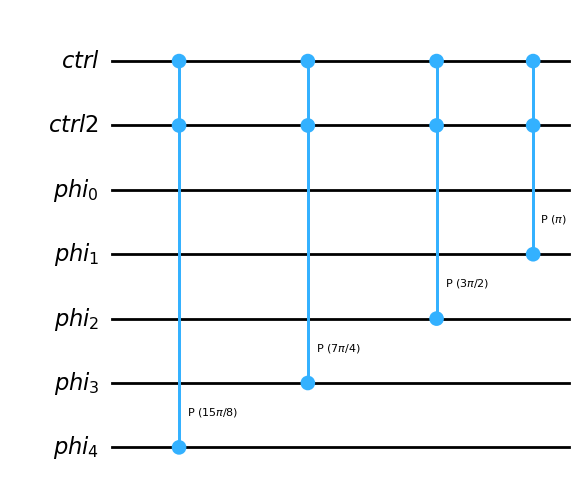

In [12]:
def C2phiADD(a, n, ctrl1, ctrl2):
    """
    Constructs a doubly controlled quantum phase addition circuit (phiADD) that adds a classical integer `a`
    to a quantum register encoded in the Fourier basis.

    Input: 
    a = Integer to add < 2**N
    n = Number of qubits
    ctrl1 = First control qubit
    ctrl2 = Second control qubit
    
    Output: Quantum Circuit for doubly controlled quantum phase addition
    
    """
    phi = QuantumRegister(n + 1, name="phi")
    qc = QuantumCircuit(ctrl1, ctrl2, phi, name=f"C2_phiADD({a})")
    a_bits = int_to_bit_array(a, n)

    for j in range(n):
        angle = 0
        for k in range(j, n):
            if a_bits[k] == 1:
                angle += 2 * np.pi / (2 ** (k - j + 1))
        if angle != 0:
            qc.mcp(angle, [ctrl1[0], ctrl2[0]], phi[n - j])

    return qc

### Example usage and circuit drawing

# number of qubits
n = 4

# integer to add, we must have a < N = 2**n
a = 15

# create the control qubits
ctrl = QuantumRegister(1, name= "ctrl")
ctrl2 = QuantumRegister(1, name="ctrl2")

# draw the quantum circuit
C2phiADD_circuit = C2phiADD(a, n, ctrl, ctrl2)
C2phiADD_circuit.draw("mpl")

Now we build the $\phi ADD(a)modN$ circuit such that
$$| \phi(b) \rangle \rightarrow | \phi((a+b)modN) \rangle$$
and is controlled by two qubits. 

We use an extra qubit in state $|0 \rangle$ so that our MSB is always zero, to avoid overflow.

We use the identity $$(a+b)modN \geq a \iff a+b <N,$$
to ensure that we can restore the ancillary qubit to $|0\rangle$. 

Running and inverse $\phi ADD$ gate followed by an inverse QFT gives us the most significant qubit of $(a+b)modN - a$.

So $|0\rangle \implies (a+b)modN \geq a \iff a+b < N$. We then apply a not gate to the MSB and target the ancilla to reverse it. $(\star)$ \


This circuit takes $n+4$ qubits. 

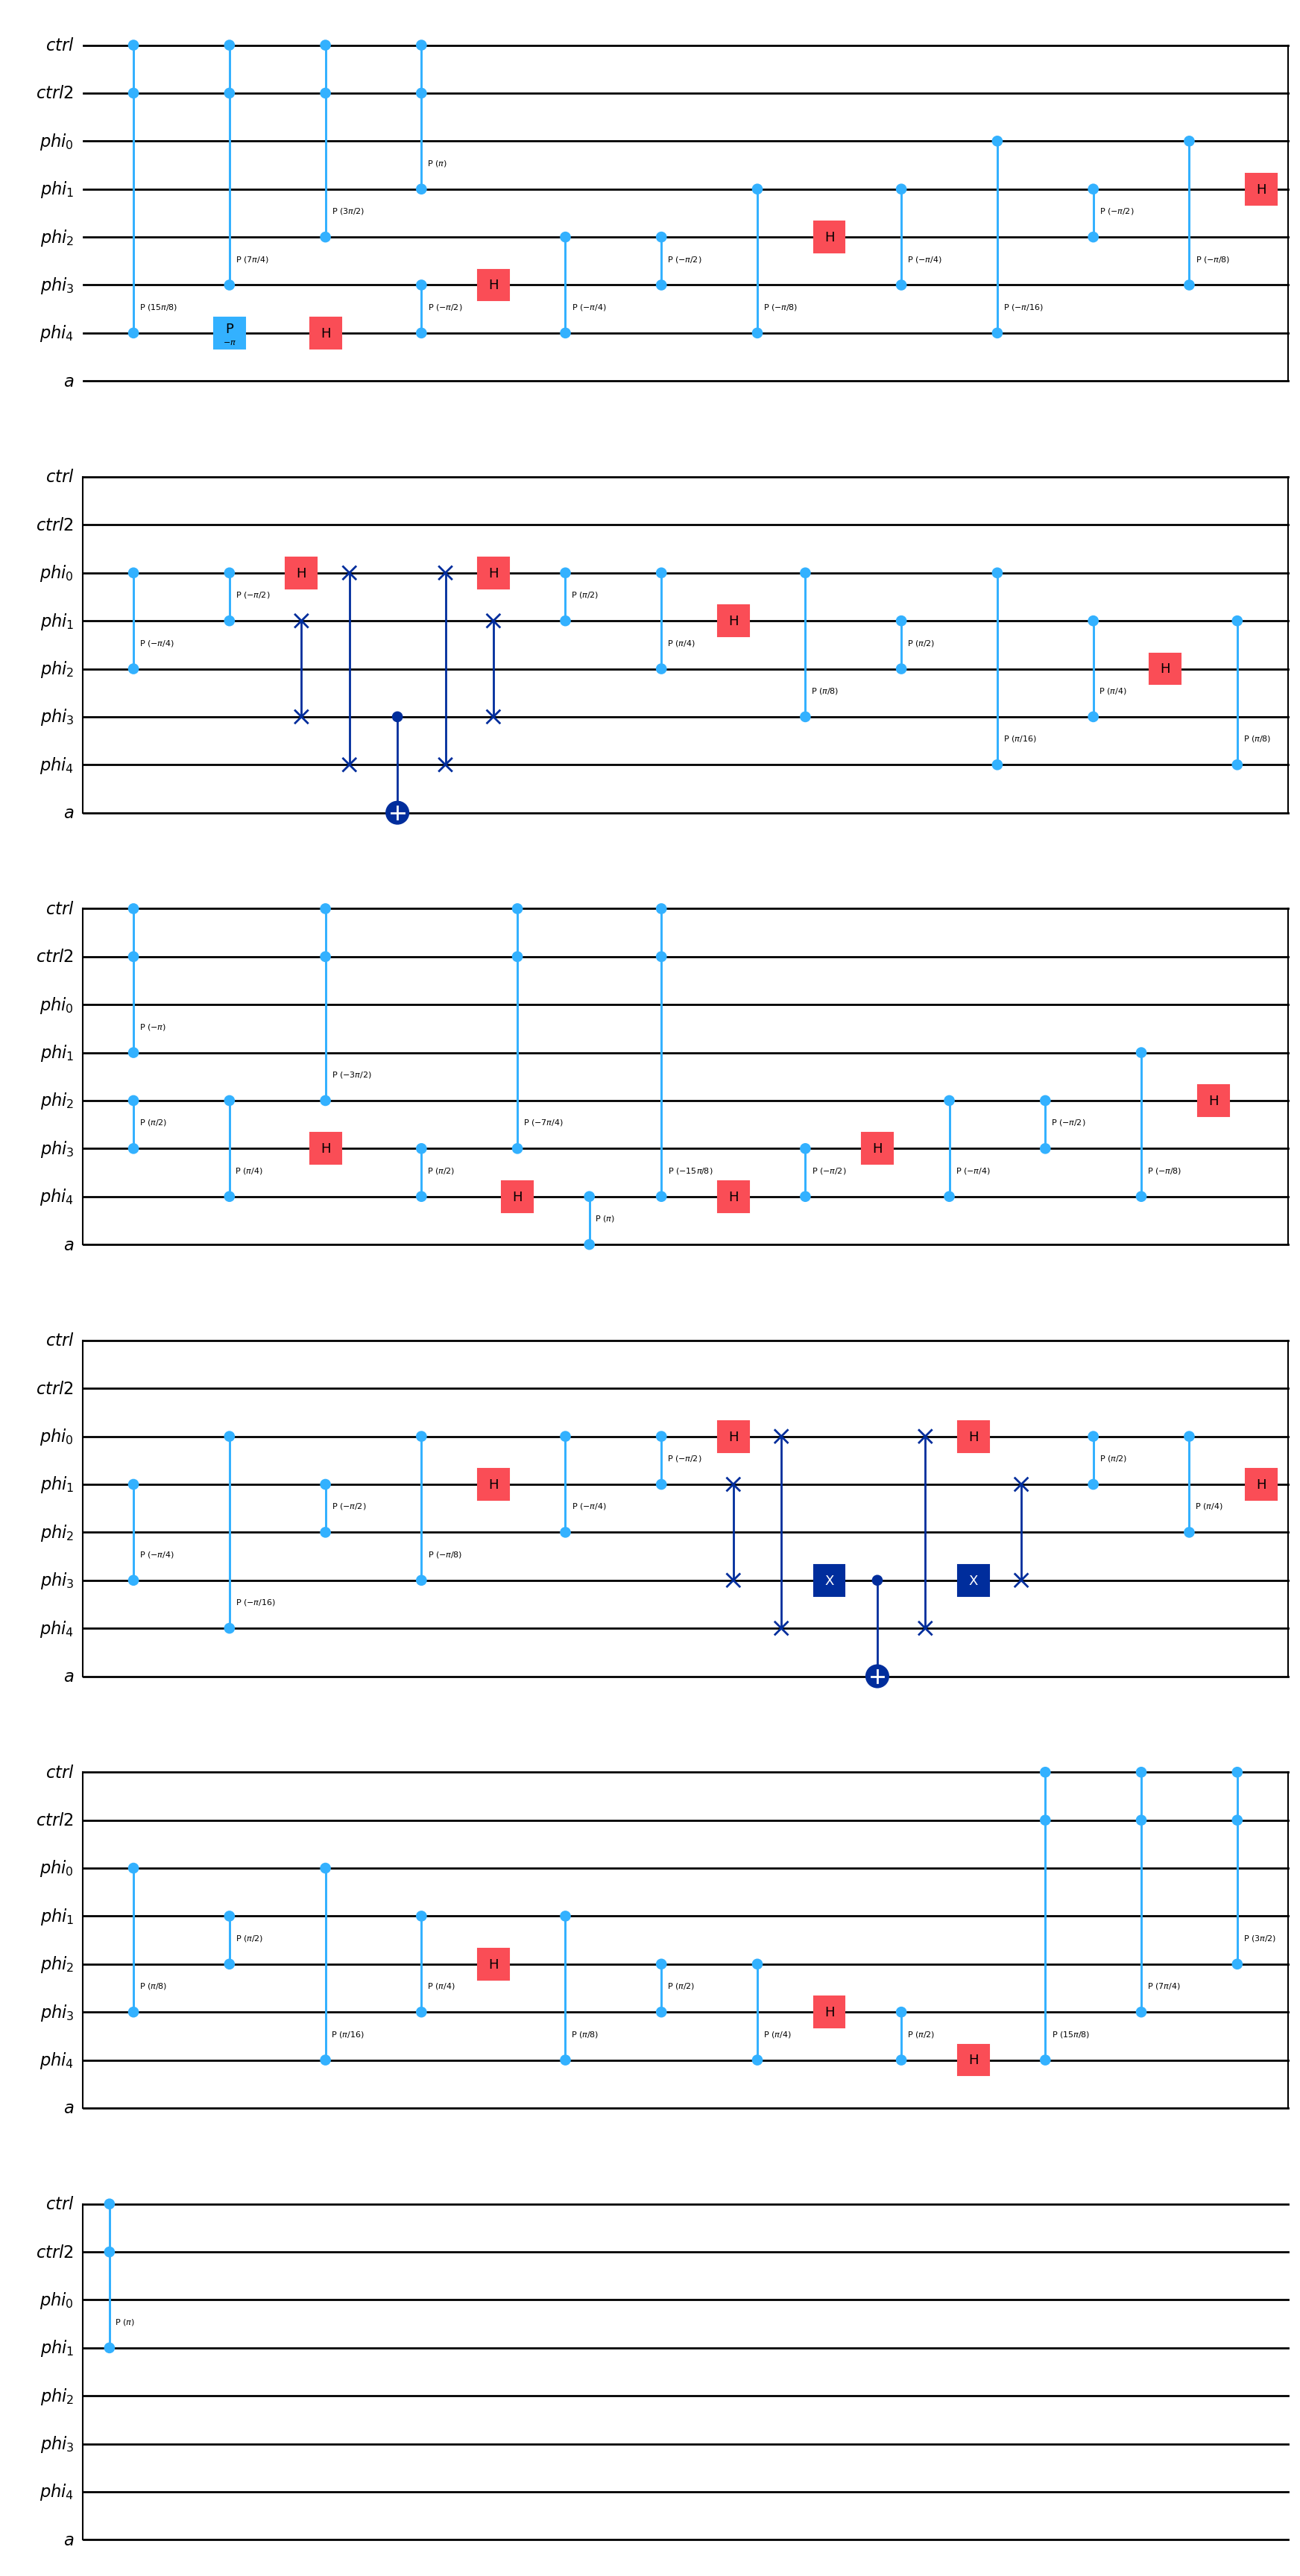

In [13]:
def C2phiADDMODN(a, n, ctrl1, ctrl2):
    """
    Constructs a doubly controlled modular addition circuit, (C2phiADDMODN), in the Fourier basis.
    Implements (b + a) mod N in the quantum Fourier transform (QFT) basis,
    where the operation is controlled by two control qubits.
    
    Input: 
    a = Integer to add < 2**N
    n = Number of qubits
    ctrl1 = First control qubit
    ctrl2 = Second control qubit
    
    Output: Quantum Circuit for doubly controlled modular addition circuit (C2phiADDMODN)
    """
    phiB = QuantumRegister(n+1, name="phi")
    ancilla = QuantumRegister(1, name="a")
    phiADDmodN = QuantumCircuit(ctrl1, ctrl2, phiB, ancilla)
    # Create and compose the controlled phiADD circuit
    
    C2phiADD_circuit = C2phiADD(a, n, ctrl1, ctrl2)
    phiADDinvN_circuit = phiADD(2**n, n).inverse() # ensures that a+b < N, when b=0, a < n pg. 6
    QFTinv_circuit = inverse_quantum_fourier_transform(n + 1)
    QFT_circuit = quantum_fourier_transform(n + 1)
    C1phiADDN_circuit = C1phiADD(2**n, n, ancilla)
    C2phiADDinv_circuit = C2phiADD(a, n, ctrl1, ctrl2).inverse()
    
    qubit_list = list(ctrl1) + list(ctrl2) + list(phiB)
    
    phiADDmodN.compose(C2phiADD_circuit, qubits=list(ctrl1) + list(ctrl2) + list(phiB), inplace=True)
    phiADDmodN.compose(phiADDinvN_circuit, qubits=list(phiB), inplace=True)
    phiADDmodN.compose(QFTinv_circuit, qubits=list(phiB), inplace=True)
    phiADDmodN.cx(phiB[n-1], ancilla[0])
    phiADDmodN.compose(QFT_circuit, qubits=list(phiB), inplace=True)
    phiADDmodN.compose(C1phiADDN_circuit, qubits=list(ancilla) + list(phiB), inplace=True)
    phiADDmodN.compose(C2phiADDinv_circuit, qubits=list(ctrl1) + list(ctrl2) + list(phiB), inplace=True)
    phiADDmodN.compose(QFTinv_circuit, qubits=list(phiB), inplace=True)
    phiADDmodN.x(phiB[n-1])
    phiADDmodN.cx(phiB[n-1], ancilla[0])
    phiADDmodN.x(phiB[n-1])
    phiADDmodN.compose(QFT_circuit, qubits=list(phiB), inplace=True)
    phiADDmodN.compose(C2phiADD_circuit, qubits=list(ctrl1) + list(ctrl2) + list(phiB), inplace=True)

    return phiADDmodN

### Example usage and circuit drawing

# number of qubits
n = 4

# integer to add, we must have a < N = 2**n
a = 15

# create the control qubits
ctrl = QuantumRegister(1, name= "ctrl")
ctrl2 = QuantumRegister(1, name="ctrl2")

# draw the quantum circuit
phiADDmodN_circuit = C2phiADDMODN(a, n, ctrl, ctrl2)
phiADDmodN_circuit.draw("mpl")

Now we use the $C^2 \phi ADDmodN$ gate to creat the controlled multiplier gate $CMultMod(N)$ so that if $|c\rangle = |1\rangle$, $$|c\rangle |x\rangle |b\rangle \rightarrow |c\rangle |x\rangle |b + (ax)modN\rangle$$
and stays the same otherwise.

We leverage the identity $$(ax)modN = (... ((2^0 ax_0) modN + 2^1 a x_1) modN + ... + 2^{n-1}ax_{n-1})modN$$

This circuit takes $2n+3$ qubits since it is $n$ doubly controlled $\phi ADDmodN$ circuits, this also means it takes $O(n^2 k_{max})$ gates and a depth of $O(n^2)$. 

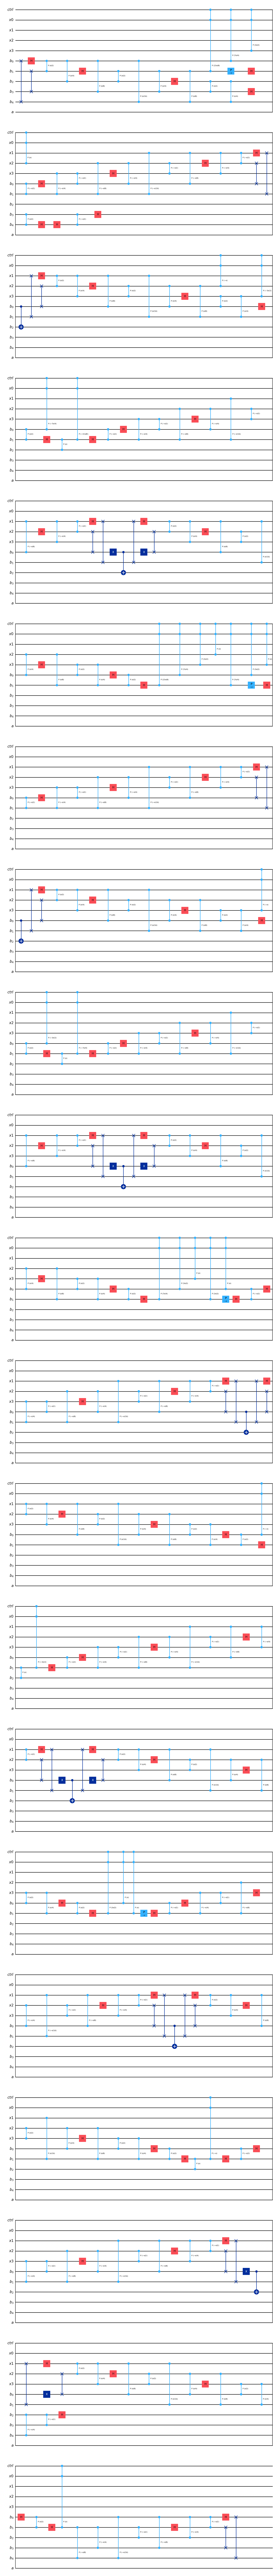

In [16]:
def CMultModN(a, n):
    """
    Constructs a quantum circuit that performs controlled modular multiplication by `a` modulo 2^n.
    This circuit is used in quantum modular exponentiation, a key component of Shor’s algorithm.

    Inputs:
    a = integer to multiply by
    n = number of qubits

    Output: A quantum circuit for controlled modular multiplication by `a` modulo 2^n.

    Registers:
    - ctrl : 1 control qubit to enable the full operation
    - x : array of n single-qubit QuantumRegisters representing bits of x
    - b : target register (n+1 qubits) storing the result in the Fourier basis
    - ancilla : 1-qubit ancilla used in modular addition
    """
    # control qubit
    ctrl = QuantumRegister(1, name="ctrl")

    # array of quantum registers to store the classical value in n qubits to control the fourier basis
    x = [QuantumRegister(1, name=f"x{i}") for i in range(n)]

    # quantum register in the fourier basis
    b = QuantumRegister(n+1, name = "b")

    # 1-qubit ancilla used in modular addition
    ancilla = QuantumRegister(1, name="a")

    CMultModN = QuantumCircuit(ctrl, *x, b, ancilla)
    
    QFT_circuit = quantum_fourier_transform(n+1)
    QFTinv_circuit = inverse_quantum_fourier_transform(n+1)
    
    CMultModN.compose(QFT_circuit, qubits=b[:], inplace = True)
    
    for j in range(n):
        a_shifted = (a * 2**j) % 2**n
        C2phiADDModN_circuit = C2phiADDMODN(a_shifted, n, ctrl, x[j])
        CMultModN.compose(C2phiADDModN_circuit, inplace=True)
    
    CMultModN.compose(QFTinv_circuit, qubits=b[:], inplace = True)

    return CMultModN

### Example usage and circuit drawing

# number of qubits
n = 4

# integer to add, we must have a < N = 2**n
a = 15

# draw the quantum circuit
CMultModN_circuit = CMultModN(a,n)
CMultModN_circuit.draw("mpl")

We will also need a CSWAP gate:

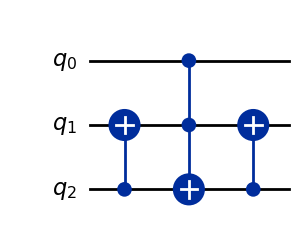

In [17]:
def CSWAP():():
    """
    Constructs a 3-qubit controlled-SWAP gate.

    This gate swaps the states of the second and third qubits **only if**
    the first (control) qubit is in the |1⟩ state.

    Qubit order (q0, q1, q2):
    - q0: Control qubit
    - q1: Target qubit 1
    - q2: Target qubit 2

    Gate decomposition:
    - A controlled-SWAP can be implemented using:
        1. CX(q2, q1)
        2. CCX(q0, q1, q2)
        3. CX(q2, q1)

    Output: QuantumCircuit implementing the CSWAP gate.
    """
    qc = QuantumCircuit(3, name="cswap")
    qc.cx(2, 1)
    qc.ccx(0, 1, 2)
    qc.cx(2, 1)
    return qc

### Example usage and circuit drawing

# draw the quantum circuit
qc = CSWAP()
qc.draw("mpl")

We can now build the final oracle by applying $CMultModN(a)$ gate, then swapping the respective qubits from the x and b registers,
and finally applying the inverse $CMultModN(a)$ gate which implements:
 $$|c \rangle |x\rangle |b \rangle \rightarrow |c \rangle | x \rangle |(b-a^{-1}x) modN \rangle$$,,

If we initialize $b$ in the zero state, and use the logic from the C2phiADDMODN gate, $(\star)$, to require $x<N$, we have $$U \, |c\rangle_1 \, |x\rangle_n =
\begin{cases}
|c\rangle_1 \, |ax \bmod N\rangle_n, & \text{if } c = 1 \text{ and } x < N, \\
|c\rangle_1 \, |x\rangle_n, & \text{otherwise}.
\end{cases}$$ 

and we have Shor's Oracle.

This circuit takes $2n+3$ qubits.

In [22]:
def ShorsOracle(a,n):
    """
    Constructs a quantum circuit implementing the modular multiplication

    The implementation follows the standard technique:
    1. Apply controlled modular multiplication by a.
    2. Swap x and b if control is active (using controlled SWAPs).
    3. Uncompute the modular multiplication.

    Inputs:
    a = Interger multiplier
    n = Number of bits for the input/output registers (x and b)

    Output: Shor's Oracle quantum circuit

    Registers:
    - ctrl    : 1 control qubit
    - x       : n-qubit input register holding x
    - b       : (n+1)-qubit target register for modular product
    - ancilla : 1 ancilla qubit used internally by modular multiplication
    """
    ctrl = QuantumRegister(1, name="ctrl")
    x = [QuantumRegister(1, name=f"x{i}") for i in range(n)]  # Give names to registers
    b = QuantumRegister(n+1, name= "b")
    ancilla = QuantumRegister(1, name="a")
    
    CUa = QuantumCircuit(ctrl, *x, b, ancilla)

    # Flatten x to list of qubits
    ctrl_qubits = [ctrl[0]]
    x_qubits = [reg[0] for reg in x]
    b_qubits = list(b)
    ancilla_qubits = list(ancilla)
    
    all_qubits = ctrl_qubits + x_qubits + b_qubits + ancilla_qubits
    
    CMultModN_circuit = CMultModN(a, n)
    
    CUa.compose(CMultModN_circuit, qubits=all_qubits, inplace=True)
    
    cswap_circ = CSWAP()
    for j in range(n):
        CUa.compose(cswap_circ, qubits=[ctrl[0], x[j][0], b[j]], inplace=True)
    
    CMultModNinv_circuit = CMultModN(a, n).inverse()
    CUa.compose(CMultModNinv_circuit, qubits=all_qubits, inplace=True)

    return CUa

### Example usage and circuit drawing

# number of qubits
n = 4

# integer to add, we must have a < N = 2**n
a = 15

# draw the quantum circuit
ShorsOracle_circuit = ShorsOracle(a,n)
ShorsOracle_circuit.draw("mpl")

In [33]:
# benchmarking
CUa_circuit = CU_a(a=7, n=4)

gate_counts = CUa_circuit.count_ops()
gate_counts_dict = dict(gate_counts)

# gate counts
print("Gate counts:", gate_counts_dict)

# Depth
print("Circuit depth:", CUa_circuit.depth())

# Ancillas
ancilla_regs = [reg for reg in CUa_circuit.qregs if 'a' in reg.name or 'anc' in reg.name]
num_ancillas = sum(len(reg) for reg in ancilla_regs)
print("Number of ancilla qubits:", num_ancillas)

Gate counts: {'cp': 368, 'h': 180, 'swap': 72, 'mcphase': 60, 'cx': 24, 'x': 16, 'p': 8, 'ccx': 4}
Circuit depth: 413
Number of ancilla qubits: 1
